# FIRST ANALYSIS WITHOUT DELETING STOPWORDS


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import ngrams
from wordcloud import WordCloud
from collections import Counter

# !pip install spacy
# !python -m spacy download fr_core_news_sm
import spacy

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test_text.csv')
validation_df = pd.read_csv('../data/validation.csv')

## <span style="background-color: green;">Analysis</span>


In [3]:
# print the first n text of the training set with their titles
n = 3
for i in range(n):
    text = train_df['text'][i]
    title = train_df['titles'][i]
    print(f'Title: {title}')
    print(f'Text: {text}')
    for line in text.split('. '):
        print(line + '.') # add the dot back
    print('\n')

Title: L'information n'a pas été confirmée par l'intéressé qui déclare toutefois étudier la question.
Text: Thierry Mariani sur la liste du Rassemblement national (RN, ex-FN) aux européennes ? C'est ce qu'affirme mardi 11 septembre Chez Pol, la nouvelle newsletter politique de Libération. L'ancien député Les Républicain et ministre de Nicolas Sarkozy serait sur le point de rejoindre les troupes de Marine Le Pen pour le élections européennes de 2019. "Ça va se faire. Ce n'est plus qu'une question de calendrier. On n'est pas obligé de l'annoncer tout de suite, à huit mois des européennes", aurait ainsi assuré un membre influent du RN. Contacté par Franceinfo, M. Mariani n'a pas confirmé l'information. "Les élections sont en juin, je ne sais même pas qui sera numéro 1 sur la liste", a répondu l'ancien ministre des Transports. Il reconnaît toutefois, toujours cité par Franceinfo, que son nom sur la liste du RN "fait partie des possibilités". "Fréjus est une ville sympathique mais je n'ai p

### `1` Exploratory Data Analysis


#### `1.a` Text Length Analysis


Text Length Description:
count    21401.000000
mean       350.335498
std        170.754518
min         33.000000
25%        231.000000
50%        313.000000
75%        423.000000
max       3163.000000
Name: text, dtype: float64

Title Length Description:
count    21401.000000
mean        32.104434
std         11.479514
min          6.000000
25%         24.000000
50%         32.000000
75%         39.000000
max        155.000000
Name: titles, dtype: float64


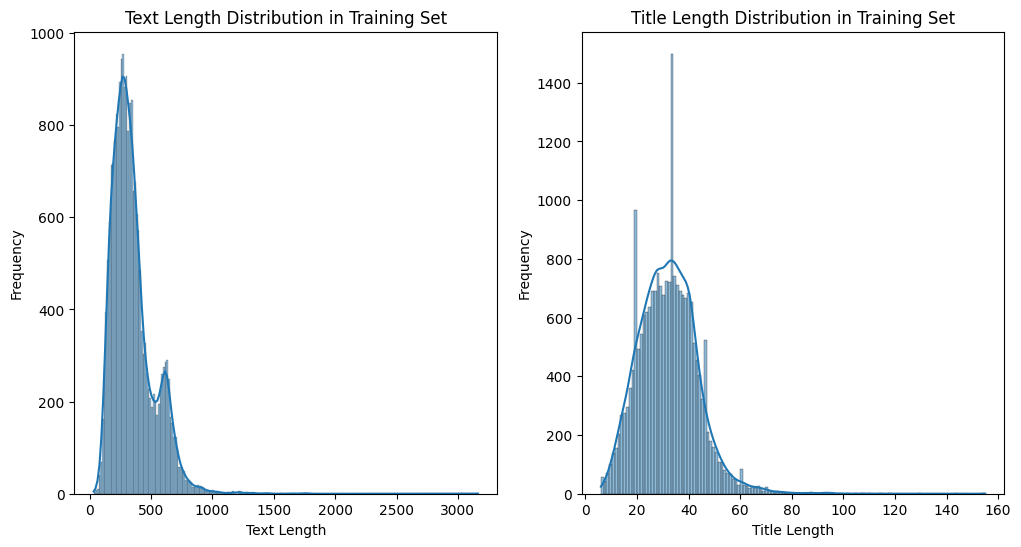

In [4]:
# describe the text length and titles length in the training set
print('Text Length Description:')
print(train_df['text'].apply(lambda x: len(x.split())).describe())
print('\nTitle Length Description:')
print(train_df['titles'].apply(lambda x: len(x.split())).describe())

# plot the text length distribution and the title length distribution in the training set

text_length = train_df['text'].apply(lambda x: len(x.split()))
title_length = train_df['titles'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(text_length, kde=True, ax=ax[0])
ax[0].set_title('Text Length Distribution in Training Set')
ax[0].set_xlabel('Text Length')
ax[0].set_ylabel('Frequency')

sns.histplot(title_length, kde=True, ax=ax[1])
ax[1].set_title('Title Length Distribution in Training Set')
ax[1].set_xlabel('Title Length')
ax[1].set_ylabel('Frequency')

plt.show()

##### Sequence Length Parameters:

For articles: 75% of our articles are 423 words or shorter. Setting a `truncation limit around the 75th percentile (around 400-450 words)` would allow us to retain most of the content for the majority of the articles while discarding the longer tail which could be outliers or exceptional cases. However, we might want to analyze the longest articles to ensure that you're not discarding important information that could be crucial for title generation.

For titles: Since the mean and median are both at 32 characters, and the standard deviation is about 11 characters, `truncating titles at around 50 characters` (mean + 1.5\*standard deviation) would likely retain most of the informative content while excluding outliers.

<span style="color: red;"> Which pproaches ? </span>

- truncates
- take the max_lenght
- use a hierarchical approach that first splits the article into sections


Correlation between text length and title length:


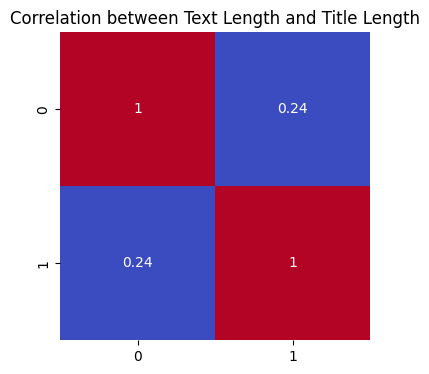

In [5]:
# Correlation between text length and title length
print('Correlation between text length and title length:')
correlation_matrix = np.corrcoef(text_length, title_length)

# plot the correlation matrix
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation between Text Length and Title Length')
plt.show()

There is a positive correlation between text length and title length. Although it's not a strong correlation, it indicates that there is a slight tendency for longer texts to have longer titles


#### `1.b` Word Frequency Analysis


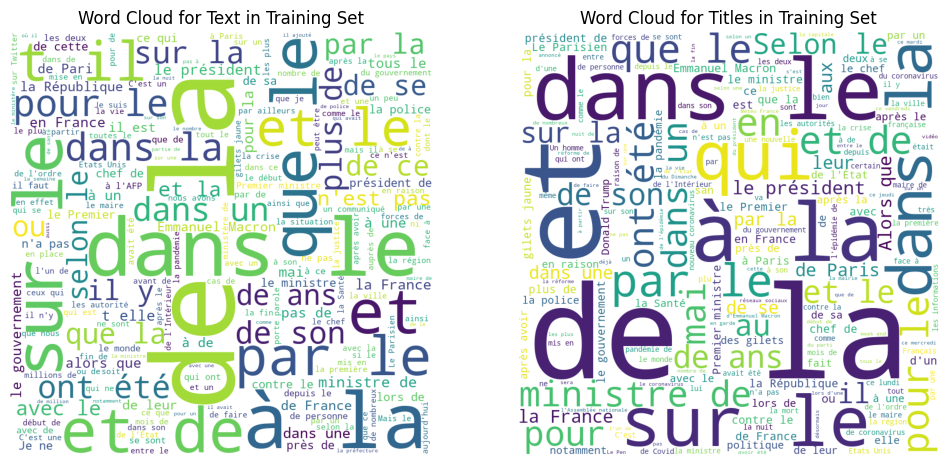

In [6]:
# plot word cloud for the text and titles in the training set
text = ' '.join(train_df['text'])
title = ' '.join(train_df['titles'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
ax[0].imshow(wordcloud)
ax[0].set_title('Word Cloud for Text in Training Set')
ax[0].axis('off')

wordcloud = WordCloud(width=800, height=800, background_color='white').generate(title)
ax[1].imshow(wordcloud)
ax[1].set_title('Word Cloud for Titles in Training Set')
ax[1].axis('off')

plt.show()

In [7]:
# Word Frequency Analysis for the text in the training set
word_freq = Counter([word.lower() for text in train_df['text'] for word in text.split() if word.isalpha()])
word_freq = pd.DataFrame(word_freq.items(), columns=['word', 'frequency'])
word_freq = word_freq.sort_values(by='frequency', ascending=False)

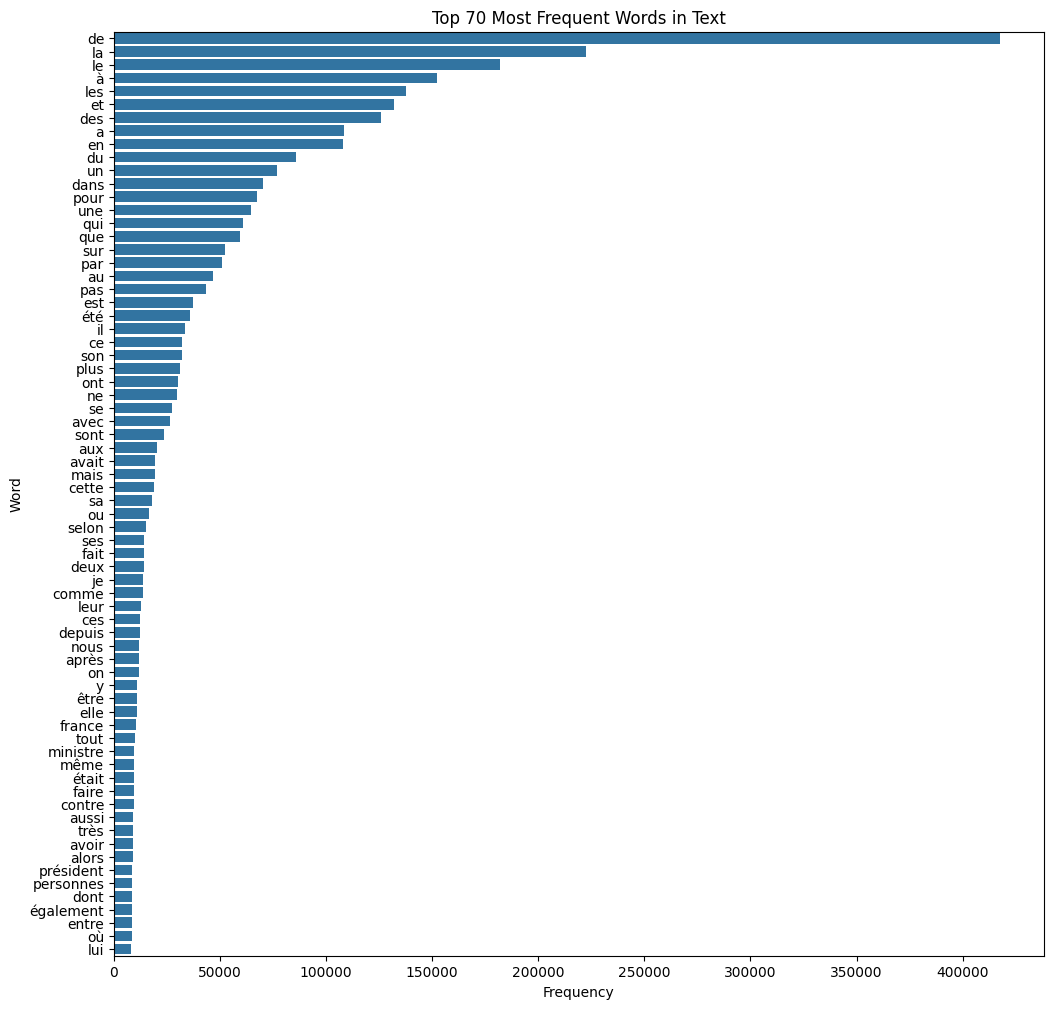

In [8]:
## Plot the top n most frequent words
n = 70
plt.figure(figsize=(12, 12))
sns.barplot(x='frequency', y='word', data=word_freq[:n])
plt.title(f'Top {n} Most Frequent Words in Text')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

- Stopwords Removal: We can try to `create our Custom Stop Words List`
- `TF-IDF Analysis`: Instead of simple frequency counts, we can use TF-IDF to give higher weight to terms that are frequent in a document but not across all documents


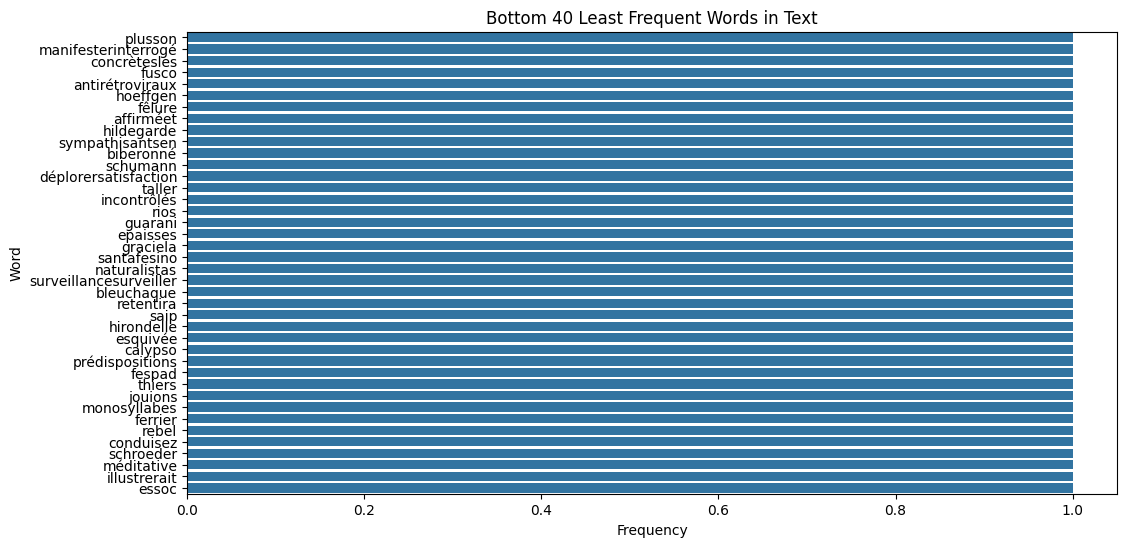

In [9]:
## Plot the bottom n least frequent words
n = 40
plt.figure(figsize=(12, 6))
sns.barplot(x='frequency', y='word', data=word_freq[-n:])
plt.title(f'Bottom {n} Least Frequent Words in Text')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

#### `1.c` N-gram Analysis


In [10]:
# N-gram Analysis for the text in the training set
N = 2
ngram_freq = Counter(ngrams([word.lower() for text in train_df['text'] for word in text.split() if word.isalpha()], N))
ngram_freq = pd.DataFrame(ngram_freq.items(), columns=['ngram', 'frequency'])
ngram_freq = ngram_freq.sort_values(by='frequency', ascending=False)

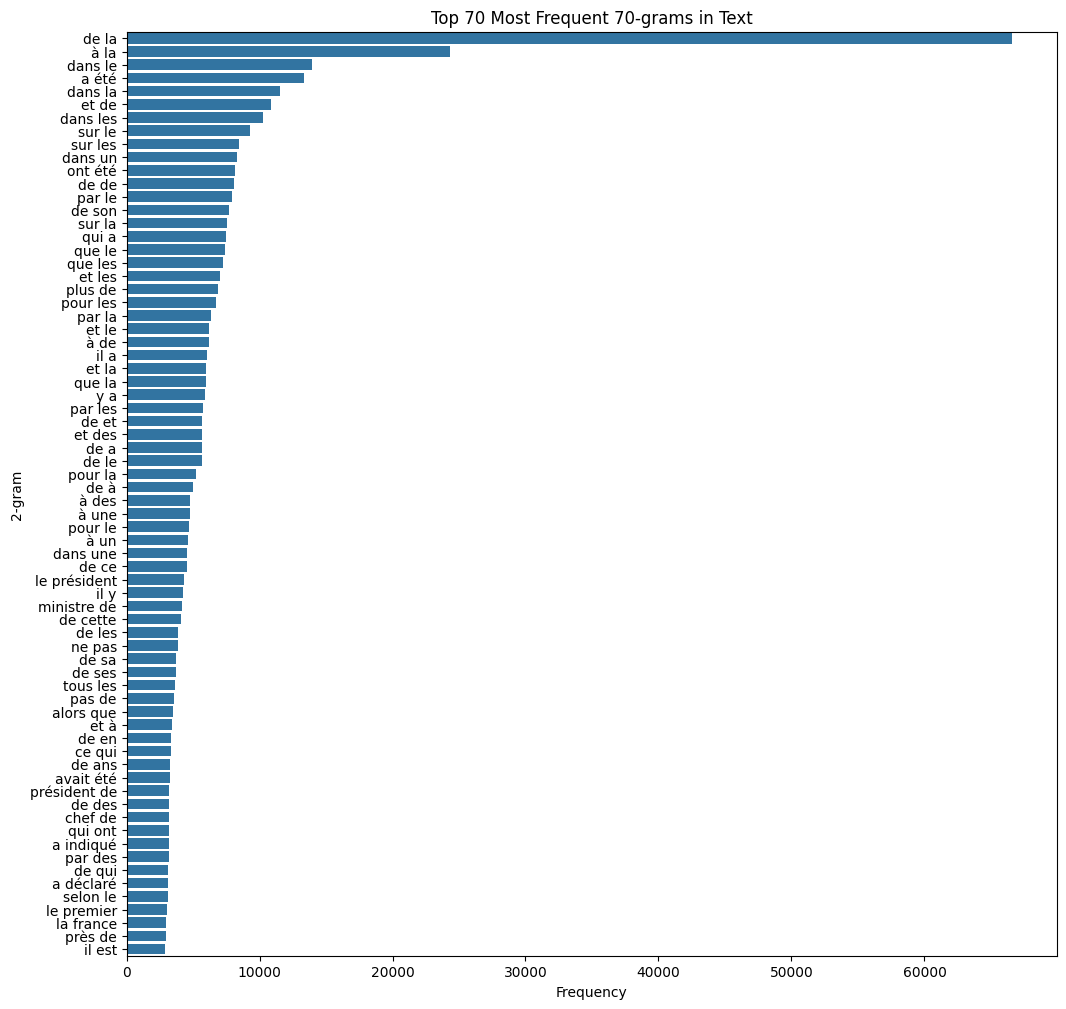

In [11]:
## Plot the top n most frequent n-grams
n = 70

x = [f'{ngram[0]} {ngram[1]}' for ngram in ngram_freq['ngram'][:n]]
y = ngram_freq['frequency'][:n]

plt.figure(figsize=(12, 12))
sns.barplot(x=y, y=x)
plt.title(f'Top {n} Most Frequent {n}-grams in Text')
plt.xlabel('Frequency')
plt.ylabel('2-gram')
plt.show()

In [12]:
# Title N-gram Overlap with Text

## Function to create n-grams
def create_ngrams(text, n):
    return list(ngrams(nltk.word_tokenize(text), n))

## Function to calculate n-gram overlap
def calculate_overlap(title, text, n):
    title_ngrams = create_ngrams(title, n)
    text_ngrams = create_ngrams(text, n)
    
    # Count n-grams in titles and texts
    title_ngram_counts = Counter(title_ngrams)
    text_ngram_counts = Counter(text_ngrams)
    
    # Calculate overlap
    overlap = sum((title_ngram_counts & text_ngram_counts).values())
    total_title_ngrams = sum(title_ngram_counts.values())
    
    # Avoid division by zero
    if total_title_ngrams == 0:
        return 0
    overlap_percentage = (overlap / total_title_ngrams) * 100
    return overlap_percentage

count    21401.000000
mean        33.053913
std         19.371909
min          0.000000
25%         18.750000
50%         28.947368
75%         43.243243
max        100.000000
Name: 2_gram_overlap, dtype: float64


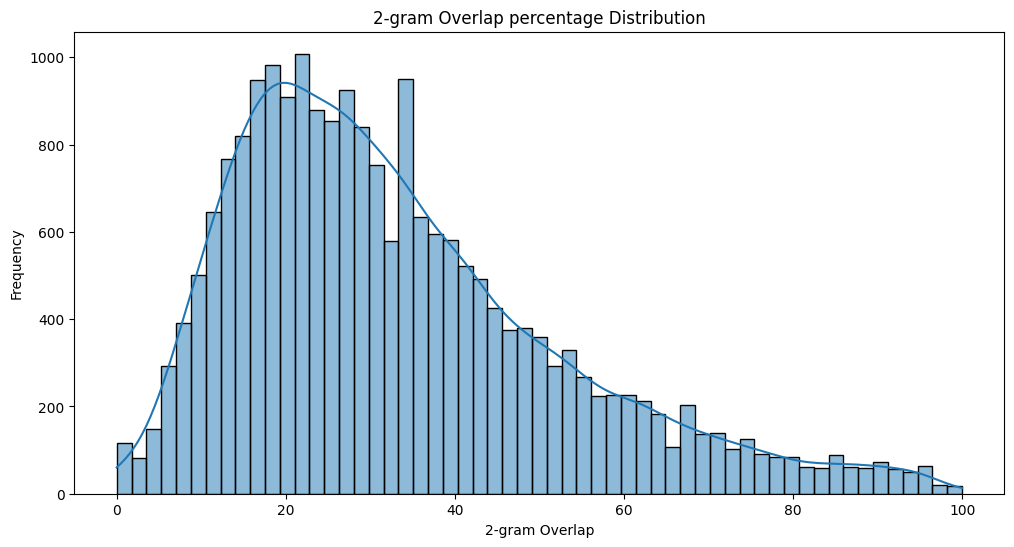

In [13]:
## Applying the calculation to the dataset for bi-grams
N = 2
train_df[f'{N}_gram_overlap'] = train_df.apply(lambda x: calculate_overlap(x['titles'], x['text'], N), axis=1)

print( train_df[f'{N}_gram_overlap'].describe() )

# Plot the distribution of 2-gram overlap
plt.figure(figsize=(12, 6))
sns.histplot(train_df[f'{N}_gram_overlap'], kde=True)
plt.title(f'{N}-gram Overlap percentage Distribution')
plt.xlabel(f'{N}-gram Overlap')
plt.ylabel('Frequency')
plt.show()

##### Implications for Model Design:

- Extractive Approach: Since there is a reasonable amount of overlap, `an extractive summarization model might perform well for a significant portion of the dataset`.

- Abstractive Techniques: However, given that the overlap is not extremely high for all titles, incorporating abstractive methods would likely be necessary to capture the titles that do not directly extract their content from the text.

- Hybrid Model: Considering the distribution, a hybrid model that can decide when to extract versus when to abstract might be beneficial.


count    21401.000000
mean        18.195909
std         18.830880
min          0.000000
25%          5.000000
50%         12.121212
75%         25.000000
max        100.000000
Name: 3_gram_overlap, dtype: float64


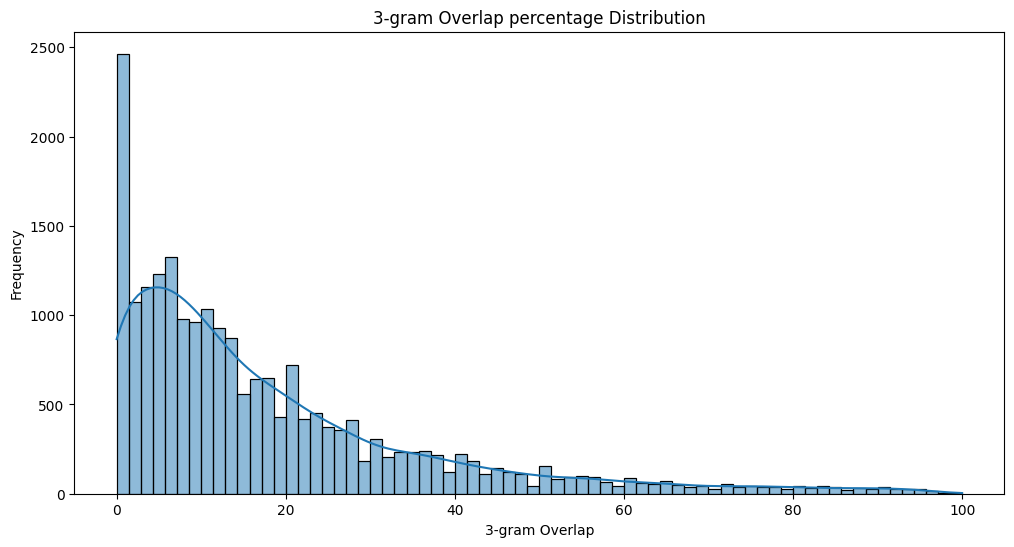

In [14]:
## Applying the calculation to the dataset for tri-grams
N = 3
train_df[f'{N}_gram_overlap'] = train_df.apply(lambda x: calculate_overlap(x['titles'], x['text'], N), axis=1)

print( train_df[f'{N}_gram_overlap'].describe() )

# Plot the distribution of 2-gram overlap
plt.figure(figsize=(12, 6))
sns.histplot(train_df[f'{N}_gram_overlap'], kde=True)
plt.title(f'{N}-gram Overlap percentage Distribution')
plt.xlabel(f'{N}-gram Overlap')
plt.ylabel('Frequency')
plt.show()

- Lower Mean Overlap: The average tri-gram overlap is about 18.20%, which is almost half that of the bi-gram overlap. This suggests that as the sequence length increases, the exact sequence is less likely to appear in both the text and the title.

- Higher Variability: The standard deviation is close to the mean, indicating a wide spread in the overlap percentage. This can mean the relationship between the text and the title varies greatly from one article to another.

- Presence of Some Direct Matches: The maximum overlap of 100% for some titles suggests there might be some titles composed of tri-grams taken directly from the text, though this is less common than with bi-grams.

- Many Titles with Low Overlap: With 25% of titles having 5% or less overlap, it is clear that a significant portion of titles do not directly take tri-grams from their corresponding texts, pointing to the necessity of abstractive summarization methods in these cases.

##### Implications for Model Design:

- Abstractive Summarization: The relatively low mean overlap for tri-grams suggests that `an abstractive model might be more appropriate for this dataset` because it needs to generate parts of the title that are not found in the text.

- Contextual Understanding: The model will need a good understanding of the text to generate relevant tri-grams that are not explicitly present in the content but capture its essence.

- Creativity in Title Generation: Since there’s a substantial number of titles with low overlap, the model will need to be capable of creative generation, which is a hallmark of advanced abstractive summarization models like those based on transformer architectures.
